# Individual -Assignment

Martin Lefèvre

In [26]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [27]:
import numpy as np
import text_flappy_bird_gym
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import pandas as pd
import plotting

As usual, we redefine the argmax function. Contrary to the numpy version, we want to break ties randomly: in case the maximum value of an array is reached several times, we want to select the index randomly instead of systemically take the first index with the maximal value.

In [28]:
def argmax(q_values):
    """
    Function to find the index of the highest value in a list of q_values.

    Arguments:
    - q_values: list - a list of q_values

    Returns:
    - int - the index of the highest value in q_values
    """

    max_value = float("-inf")
    ties_list = []
    
    for i in range(len(q_values)):
        # if the current max_value is outperformed, then reset the ties list and add the new index
        if q_values[i] > max_value:
            max_value = q_values[i]
            ties_list = [i]
        # if the current max_value is equaled, then add the index to ties
        elif q_values[i] == max_value:
            ties_list.append(i)
    
    # return a random selection from ties
    ind = np.random.choice(ties_list)
    
    return ind

## Monte Carlo

Let's start with a Monte Carlo agent. This agent chooses at each step the action with the best Q-values. These latter are updated at the end of the episode only, using a discount valuation method.

In [66]:
class MonteCarloAgent:
    def __init__(self, env, gamma=0.99):
        """
        Initializes the Monte Carlo Agent.

        Parameters:
            env: Object. The environment for the agent to interact with.
            gamma: float, optional. The discount factor for future rewards. Defaults to 0.99.
        """
        self.env = env
        self.gamma = gamma
        self.q_values = {}  # Q-values for state-action pairs
        self.returns = {}   # Stores returns for each state-action pair
        self.rewards = []  # Store total rewards per episode

    def play_episode(self, epsilon, config_env):
        """
        Runs one episode of the environment.
        Parameters:
            epsilon: float. The exploration-exploitation trade-off parameter.

        Returns:
            states: list. List of states encountered during the episode.
            actions: list. List of actions taken at each state during the episode.
            rewards: list. List of rewards received at each state during the episode.
            score: int. The total score achieved in the episode.
            best_action_chosen: list. List indicating whether the best action was chosen at each step.
        """
        states = []
        actions = []
        rewards = []
        state, info = self.env.reset()
        best_action_chosen = []
        while True:
            action = self.get_action(state, epsilon)
            best_action = argmax(self.get_q_values(state))        

            if action == best_action:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            next_state, reward, done, _ , info= self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if done:
                break

            state = next_state
        
        return states, actions, rewards, info['score'], best_action_chosen
    
    def play(self, epsilon=0):
        """
        Plays a single episode without exploration (epsilon=0).
        Parameters:
            epsilon: float, optional. The exploration-exploitation trade-off parameter. Defaults to 0.

        Returns:
            total_reward: float. The total reward achieved in the episode.
        """
        state, _ = self.env.reset()
        total_reward = 0
        while True and total_reward < 1000:
            action = self.get_action(state, epsilon = epsilon)  # Choose the best action
            state, reward, done, _ , _= self.env.step(action)
            total_reward += reward
            if done:
                break
        return total_reward

    def get_action(self, state, epsilon):
        """
        Selects an action based on epsilon-greedy policy.
        Parameters:
            state: object. The current state of the environment.
            epsilon: float. The exploration-exploitation trade-off parameter.

        Returns:
            action: int. The chosen action.
        """
        if np.random.rand() < epsilon:
            if self.convert_state_to_tuple(state) not in self.q_values:
                self.q_values[self.convert_state_to_tuple(state)] = np.zeros(self.env.action_space.n)
            return self.env.action_space.sample()
        else:
            return argmax(self.get_q_values(state))
        
    def convert_state_to_tuple(self, state):
        """
        Converts the state representation to a tuple if it's not already in tuple format.
        Parameters:
            state: object. The state representation.

        Returns:
            tuple_state: tuple. The state representation as a tuple.
        """
        if type(state) == tuple:
            return state
        elif type(state) == np.ndarray:
            return tuple(state.flatten())
        
    def get_q_values(self, state):
        """
        Gets Q-values for a given state.
        Parameters:
            state: object. The current state of the environment.

        Returns:
            q_values: array. The Q-values for the given state.
        """
        if self.convert_state_to_tuple(state) not in self.q_values:
            #add the state to the q_values dictionary and initialize it with zeros
            self.q_values[self.convert_state_to_tuple(state)] = np.zeros(self.env.action_space.n)
        return self.q_values[self.convert_state_to_tuple(state)]

    
    def update_q_values(self, states, actions, rewards):
        """
        Updates Q-values based on returns.
        Parameters:
            states: list. List of states encountered during the episode.
            actions: list. List of actions taken at each state during the episode.
            rewards: list. List of rewards received at each state during the episode.
        """
        returns = 0
        for t in reversed(range(len(states))):
            action = actions[t]
            state = states[t]
            returns = self.gamma * returns + rewards[t]



            if (self.convert_state_to_tuple(state), action) not in self.returns:
                self.returns[(self.convert_state_to_tuple(state), action)] = []

            self.returns[(self.convert_state_to_tuple(state), action)].append(returns)
            self.q_values[self.convert_state_to_tuple(state)][action] = np.mean(self.returns[(self.convert_state_to_tuple(state), action)])
    
    def train(self, num_episodes=1000,epsilon=0.1):
        """
        Trains the agent through multiple episodes.
        Parameters:
            num_episodes: int, optional. The number of episodes to train the agent. Defaults to 1000.
            epsilon: float, optional. The exploration-exploitation trade-off parameter. Defaults to 0.1.

        Returns:
            n_best_actions: list. List containing the percentage of times the best action was chosen.
        """
        n_best_actions = []
        for _ in tqdm(range(num_episodes)):
            states, actions, rewards, _, best_action_chosen = self.play_episode(epsilon=epsilon)
            total_reward = self.play(epsilon=0)
            self.rewards.append(total_reward)
            self.update_q_values(states, actions, rewards)
            n_best_actions.append(np.mean(best_action_chosen))
        return n_best_actions
    
    def plot_rewards(self):
        """
        Plots the total rewards per episode over training and visualizes state values as a 3D scatter plot.
        """
        # Plot score
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
        #plt.plot(self.rewards, label='Total rewards per episode')
        plt.scatter(x= np.arange(len(self.rewards)), y=self.rewards, label='Total rewards per episode', color='r')
        # Plot the mean score
        plt.plot(pd.Series(self.rewards).rolling(100).mean(), label='Average rewards over the 100 last episodes') #plot rolling average
        plt.title("Total rewards per episode")
        plt.xlabel("Steps")
        plt.ylabel("Total rewards")
        plt.legend()
        plt.show()

    def plot_state_value_function(self):
        """Plot the state-value function of the agent

        Args:
            agent (type): Agent object
        """
        
        states = list(self.q_values.keys())
        states_x = [state[0] for state in states]
        states_y = [state[1] for state in states]
        x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
        y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.zeros_like(X)

        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                state = (x_vals[i], y_vals[j])
                # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                if state in self.q_values:
                    Z[j, i] = max(self.q_values[state])
                else:
                    Z[j, i] = 0 

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_xlabel('Distance on x-axis')
        ax.invert_xaxis()
        ax.set_ylabel('Distance on y-axis')
        ax.set_zlabel('State Value')
        ax.set_title('State-Value Function')
        plt.show()
    
    def plot_policy(self):
        states = list(self.q_values.keys())
        states_x = [state[0] for state in states]
        states_y = [state[1] for state in states]
        x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
        y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.zeros_like(X)

        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                state = (x_vals[i], y_vals[j])
                # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                if state in self.q_values:
                    Z[j, i] = argmax(self.q_values[state])
                else:
                    Z[j, i] = 0 

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111)
        cax = ax.imshow(Z, cmap='Blues', origin='lower')
        ax.set_xlabel('Distance on x-axis')
        ax.invert_xaxis()
        ax.set_ylabel('Distance on y-axis')
        ax.set_title('Policy')
        fig.colorbar(cax)
        plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:45<00:00, 14.28it/s]


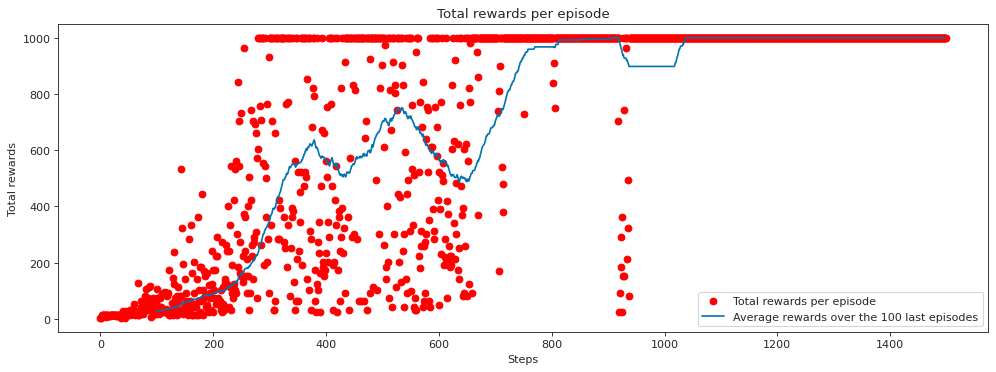

In [45]:
env = gym.make('TextFlappyBird-v0') 
agent = MonteCarloAgent(env, gamma=0.9)
agent.train(num_episodes=1500,epsilon=0.2)
agent.plot_rewards()

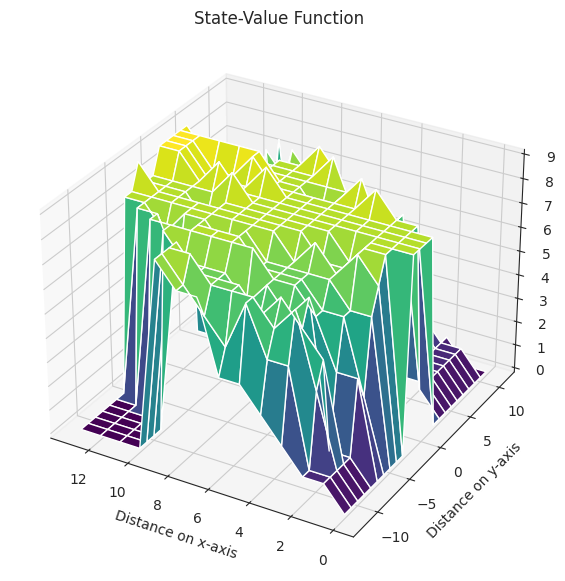

In [46]:
agent.plot_state_value_function()

The plots above show that the q_values are low when the distance to the wall is small, except in the middle because the gates have a higher probability to be there (which means that it is easier for the agent to go through when positioned in the middle). The q_values are also high when the agent is far from the wall because it still has time to adapt so its y-axis position does not compromises its chances to go through.

In [47]:
#create function to display the policy for each state
def plot_policy(agent):
    states = list(agent.q_values.keys())
    states_x = [state[0] for state in states]
    states_y = [state[1] for state in states]
    x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
    y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(len(x_vals)):
        for j in range(len(y_vals)):
            state = (x_vals[i], y_vals[j])
            # If the state is in the Q-table, take the maximum Q-value for the state, else 0
            if state in agent.q_values:
                Z[j, i] = argmax(agent.q_values[state])
            else:
                Z[j, i] = 0 

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    cax = ax.imshow(Z, cmap='Blues', origin='lower')
    ax.set_xlabel('Distance on x-axis')
    ax.set_ylabel('Distance on y-axis')
    ax.set_title('Policy')
    ax.invert_xaxis()
    fig.colorbar(cax)
    plt.show()

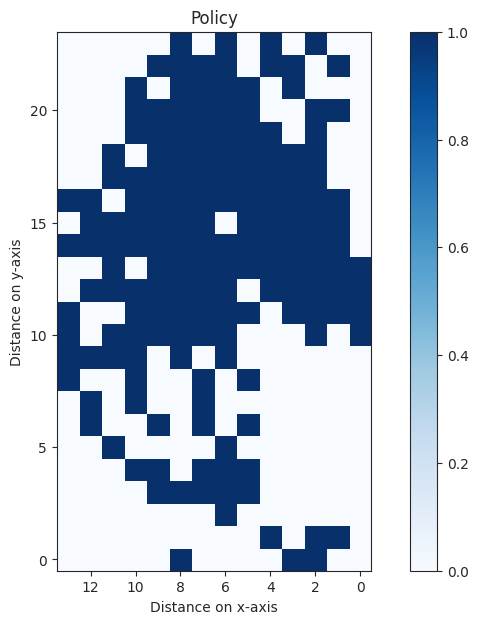

In [48]:
agent.plot_policy()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 117.74it/s]


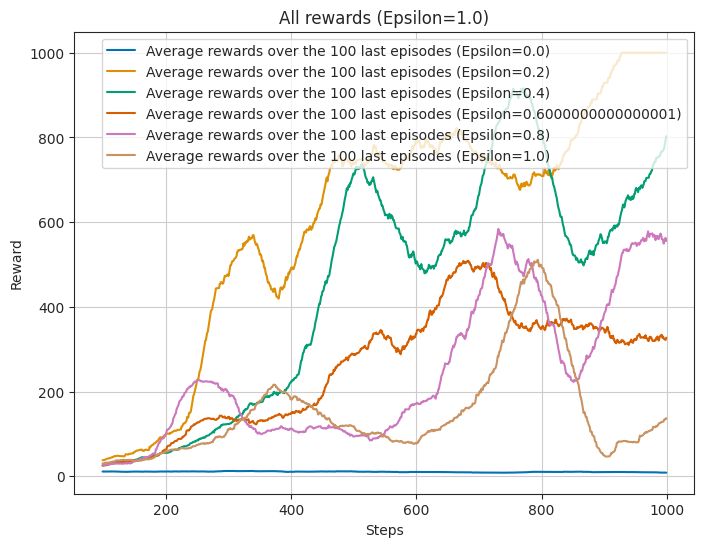

In [31]:
# Test various options for epsilon
epsilons = np.arange(0, 1.2, 0.2)
rewards = {epsilon: [] for epsilon in epsilons}

# Train the agent with different epsilon values
for epsilon in epsilons:
    agent = MonteCarloAgent(env, gamma=0.9)
    agent.train(num_episodes=1000, epsilon=epsilon)
    rewards[epsilon] = agent.rewards

# Plot the different graphs
plt.figure(figsize=(8, 6))
for i, epsilon in enumerate(epsilons):
    
    #plt.plot(rewards[epsilon], label=f"Epsilon={epsilon}")
    plt.plot(pd.Series(rewards[epsilon]).rolling(100).mean(), label=f"Average rewards over the 100 last episodes (Epsilon={epsilon})") #plot rolling average
plt.title(f"All rewards (Epsilon={epsilon})")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

We can notice that exploration has a high influence on the quality of training. The plots above clearly suggest to keep $\varepsilon = 0.2$ as the game achieves high scores more rapidly.

## Lambda Sarsa Agent

In this section, we will implement the Sarsa Agent.

The first agent is ooded for a tuple

In [67]:
class SarsaLambdaAgent:
    def __init__(self, env, alpha, gamma, lambd):
        """
        Initializes the SarsaLambdaTuple agent.
        Parameters:
            env: Object. The environment for the agent to interact with.
            alpha: float. The learning rate.
            gamma: float. The discount factor for future rewards.
            lambd: float. The lambda value for eligibility traces.
        """
        self.env = env
        self.num_states_x = env.observation_space[0].n 
        self.num_states_y = env.observation_space[1].n
        
        self.num_actions = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.Q = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))  # Initialize Q-values
        self.E = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))  # Initialize Eligibility traces
        self.actions = np.arange(self.num_actions)  # Possible actions
        self.rewards = []  # Store all rewards per episode
        self.states = []
    
    def get_action(self, state, epsilon):
        """
        Chooses an action based on epsilon-greedy policy.
        Parameters:
            state: tuple. The current state of the environment.
            epsilon: float. The exploration-exploitation trade-off parameter.

        Returns:
            action: int. The chosen action.
        """
        if np.random.rand() < epsilon:
            return np.random.choice(self.actions)  # Random exploration
        else:
            return argmax(self.Q[state[0], state[1]+9, :])  # Choose the action with highest Q-value
    
    def update_q_values(self, state, action, reward, next_state, next_action):
        """
        Updates Q-values using Sarsa(λ) algorithm.

        Parameters:
            state: tuple. The current state of the environment.
            action: int. The action taken at the current state.
            reward: float. The reward received after taking the action.
            next_state: tuple. The next state of the environment.
            next_action: int. The action to be taken at the next state.
        """
        delta = reward + self.gamma * self.Q[next_state[0], next_state[1]+9, next_action] - self.Q[state[0], state[1]+9, action] #be careful with the indexing, as y-axis component can be negative but not the index
        self.E[state[0], state[1]+9, action] += 1  # Update Eligibility traces
        for i in range(self.num_states_x):
            for j in range(self.num_states_y):
                for a in range(self.num_actions):
                    self.Q[i, j, a] += self.alpha * delta * self.E[i, j, a]  # Update Q-value
                    self.E[i, j, a] *= self.gamma * self.lambd  # Decay Eligibility traces

    def play_episode(self, epsilon):
        """
        Plays one episode of the environment.

        Parameters:
            epsilon: float. The exploration-exploitation trade-off parameter.

        Returns:
            states: list. List of states encountered during the episode.
            actions: list. List of actions taken during the episode.
            rewards: list. List of rewards received during the episode.
        """
        states = []
        actions = []
        rewards = [0]
        self.E = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))  # Reset Eligibility traces
        state, _ = self.env.reset()
        action = self.get_action(state, epsilon)
        states.append(state)
        actions.append(action)

        while True:
            next_state, reward, done, _, _ = self.env.step(action)
            rewards.append(reward)
            next_action = self.get_action(next_state, epsilon)
            self.update_q_values(state, action, reward, next_state, next_action)

            state = next_state
            action = next_action

            states.append(state)
            actions.append(action)


            if done:
                break

            state = next_state
        
        return states, actions, rewards

    def play(self, epsilon=0):
        """
        Plays a single episode without exploration.

        Parameters:
            epsilon: float, optional. The exploration-exploitation trade-off parameter. Defaults to 0.

        Returns:
            total_reward: float. The total reward achieved in the episode.
        """
        state, _ = self.env.reset()
        
        total_reward = 0
        while True and total_reward < 1000:
            action = self.get_action(state, epsilon=epsilon)  # Choose the best action
            state, reward, done, _, _ = self.env.step(action)
            total_reward += reward
            if done:
                break
        return total_reward
    
    def train(self, num_episodes, epsilon=0.1):
        """
        Trains the agent through multiple episodes.

        Parameters:
            num_episodes: int. The number of episodes to train the agent.
            epsilon: float, optional. The exploration-exploitation trade-off parameter. Defaults to 0.1.

        Returns:
            rewards: list. List of total rewards per episode.
        """
    
        
        for _ in tqdm(range(num_episodes)):
            states, actions, rewards = self.play_episode(epsilon=epsilon) # Play an episode with exploration to train the agent (Q-values are updated here)
            
            #total_reward = sum(rewards)
            total_reward = self.play(epsilon=0) # Play an episode without exploration to evaluate the agent at this point
            self.rewards.append(total_reward)

        return self.rewards

    
    def plot_rewards(self):
        """
        Plots the total rewards per episode over training and visualizes state values as a 3D scatter plot.
        """
        # Plot score
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
        #plt.plot(self.rewards, label='Total rewards per episode')
        plt.scatter(x= np.arange(len(self.rewards)), y=self.rewards, label='Total rewards per episode', color='r', s=10)

        # Plot the mean score
        plt.plot(pd.Series(self.rewards).rolling(100).mean(), label='Average rewards over the 100 last episodes') #plot rolling average
        plt.title("Total rewards per episode")
        plt.xlabel("Steps")
        plt.ylabel("Total rewards")
        plt.legend()
        plt.show()
    
    def plot_state_value_function(self):
        """Plot the state-value function of the agent

        Args:
            agent (type): Agent object
        """
        q_values = {(i,j): self.Q[i,j] for i in range(self.num_states_x) for j in range(self.num_states_y)}
        states = list(q_values.keys())
        states_x = [state[0] for state in states]
        states_y = [state[1] for state in states]
        x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
        y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.zeros_like(X)

        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                state = (x_vals[i], y_vals[j])
                # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                if state in q_values:
                    Z[j, i] = max(q_values[state])
                else:
                    Z[j, i] = 0 

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_xlabel('Distance on x-axis')
        ax.invert_xaxis()
        ax.set_ylabel('Distance on y-axis')
        ax.set_zlabel('State Value')
        ax.set_title('State-Value Function')
        plt.show()
    
    def plot_policy(self):
        q_values = {(i,j): self.Q[i,j] for i in range(self.num_states_x) for j in range(self.num_states_y)}
        states = list(q_values.keys())
        states_x = [state[0] for state in states]
        states_y = [state[1] for state in states]
        x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
        y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.zeros_like(X)

        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                state = (x_vals[i], y_vals[j])
                # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                if state in q_values:
                    Z[j, i] = argmax(q_values[state])
                else:
                    Z[j, i] = 0 

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111)
        cax = ax.imshow(Z, cmap='Blues', origin='lower')
        ax.set_xlabel('Distance on x-axis')
        ax.invert_xaxis()
        ax.set_ylabel('Distance on y-axis')
        ax.set_title('Policy')
        fig.colorbar(cax)
        plt.show()


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:08<00:00, 21.96it/s]


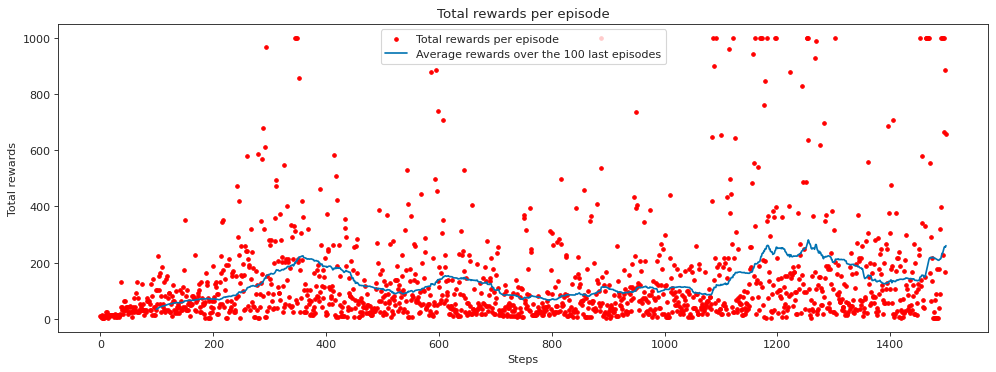

In [69]:
env = gym.make('TextFlappyBird-v0')
epsilon = 0.5
alpha = 0.3
gamma = 0.99
lambd = 0.9

sarsa_agent = SarsaLambdaAgent(env, alpha, gamma, lambd)
sarsa_agent.train(num_episodes=1500, epsilon=epsilon)
sarsa_agent.plot_rewards()

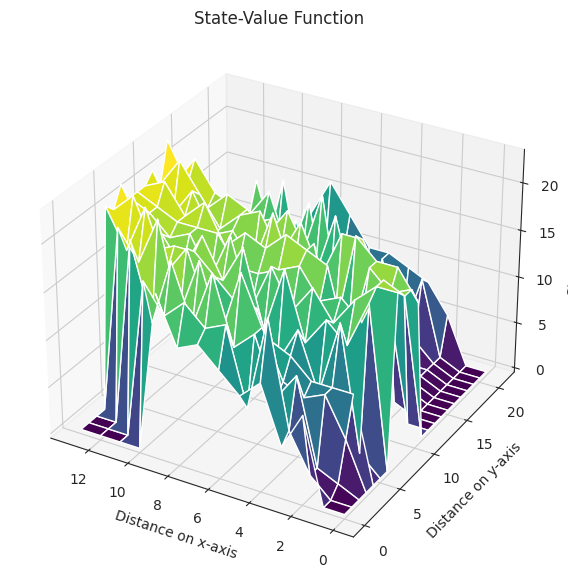

In [72]:
sarsa_agent.plot_state_value_function()

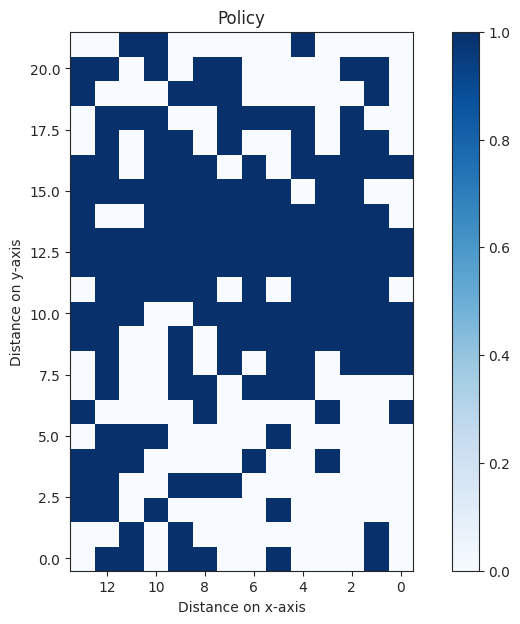

In [73]:
sarsa_agent.plot_policy()

## Annexes

### Monte Carlo section

Now, let's test our best agent (Monte Carlo) with various game configurations. A few arrangements on the class are necessary to adapt it to the task. The principle remains the same. It simply consists in enabling the testing of an agent on a different environment than the one it was trained on.

In [102]:
class MonteCarloAgentConfig:
    def __init__(self, env, gamma=0.99):
        """
        Initializes the Monte Carlo Agent.

        Parameters:
            env: Object. The environment for the agent to interact with.
            gamma: float, optional. The discount factor for future rewards. Defaults to 0.99.
        """
        self.env = env
        self.gamma = gamma
        self.q_values = {}  # Q-values for state-action pairs
        self.returns = {}   # Stores returns for each state-action pair
        self.rewards = []  # Store total rewards per episode

    def play_episode(self, epsilon):
        """
        Runs one episode of the environment.
        Parameters:
            epsilon: float. The exploration-exploitation trade-off parameter.

        Returns:
            states: list. List of states encountered during the episode.
            actions: list. List of actions taken at each state during the episode.
            rewards: list. List of rewards received at each state during the episode.
            score: int. The total score achieved in the episode.
            best_action_chosen: list. List indicating whether the best action was chosen at each step.
        """
        states = []
        actions = []
        rewards = []
        state, info = self.env.reset()
        best_action_chosen = []
        while True:
            action = self.get_action(state, epsilon)
            best_action = argmax(self.get_q_values(state))        

            if action == best_action:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            next_state, reward, done, _ , info= self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if done:
                break

            state = next_state
        
        return states, actions, rewards, info['score'], best_action_chosen
    
    def play(self, config_env, epsilon=0):
        """
        Plays a single episode without exploration (epsilon=0).
        Parameters:
            epsilon: float, optional. The exploration-exploitation trade-off parameter. Defaults to 0.

        Returns:
            total_reward: float. The total reward achieved in the episode.
        """
        state, _ = config_env.reset()
        total_reward = 0
        counter = 0
        while True and total_reward < 1000:
            counter += 1
            action = self.get_action(state, epsilon = epsilon)  # Choose the best action
            state, reward, done, _ , _= config_env.step(action)
            total_reward += reward
            if done:
                break
        return total_reward

    def get_action(self, state, epsilon):
        """
        Selects an action based on epsilon-greedy policy.
        Parameters:
            state: object. The current state of the environment.
            epsilon: float. The exploration-exploitation trade-off parameter.

        Returns:
            action: int. The chosen action.
        """
        if np.random.rand() < epsilon:
            if self.convert_state_to_tuple(state) not in self.q_values:
                self.q_values[self.convert_state_to_tuple(state)] = np.zeros(self.env.action_space.n)
            return self.env.action_space.sample()
        else:
            return argmax(self.get_q_values(state))
        
    def convert_state_to_tuple(self, state):
        """
        Converts the state representation to a tuple if it's not already in tuple format.
        Parameters:
            state: object. The state representation.

        Returns:
            tuple_state: tuple. The state representation as a tuple.
        """
        if type(state) == tuple:
            return state
        elif type(state) == np.ndarray:
            return tuple(state.flatten())
        
    def get_q_values(self, state):
        """
        Gets Q-values for a given state.
        Parameters:
            state: object. The current state of the environment.

        Returns:
            q_values: array. The Q-values for the given state.
        """
        if self.convert_state_to_tuple(state) not in self.q_values:
            #add the state to the q_values dictionary and initialize it with zeros
            self.q_values[self.convert_state_to_tuple(state)] = np.zeros(self.env.action_space.n)
        return self.q_values[self.convert_state_to_tuple(state)]

    
    def update_q_values(self, states, actions, rewards):
        """
        Updates Q-values based on returns.
        Parameters:
            states: list. List of states encountered during the episode.
            actions: list. List of actions taken at each state during the episode.
            rewards: list. List of rewards received at each state during the episode.
        """
        returns = 0
        for t in reversed(range(len(states))):
            action = actions[t]
            state = states[t]
            returns = self.gamma * returns + rewards[t]

            if (self.convert_state_to_tuple(state), action) not in self.returns:
                self.returns[(self.convert_state_to_tuple(state), action)] = []

            self.returns[(self.convert_state_to_tuple(state), action)].append(returns)
            self.q_values[self.convert_state_to_tuple(state)][action] = np.mean(self.returns[(self.convert_state_to_tuple(state), action)])
    
    def train(self, num_episodes=1000,epsilon=0.1):
        """
        Trains the agent through multiple episodes.
        Parameters:
            num_episodes: int, optional. The number of episodes to train the agent. Defaults to 1000.
            epsilon: float, optional. The exploration-exploitation trade-off parameter. Defaults to 0.1.

        Returns:
            n_best_actions: list. List containing the percentage of times the best action was chosen.
        """
        n_best_actions = []
        for _ in tqdm(range(num_episodes)):
            states, actions, rewards, _, best_action_chosen = self.play_episode(epsilon=epsilon)
            total_reward = self.play(self.env, epsilon=0)
            self.rewards.append(total_reward)
            self.update_q_values(states, actions, rewards)
            n_best_actions.append(np.mean(best_action_chosen))
        return n_best_actions
    
    def plot_rewards(self):
        """
        Plots the total rewards per episode over training and visualizes state values as a 3D scatter plot.
        """
        # Plot score
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
        #plt.plot(self.rewards, label='Total rewards per episode')
        plt.scatter(x= np.arange(len(self.rewards)), y=self.rewards, label='Total rewards per episode', color='r')
        # Plot the mean score
        plt.plot(pd.Series(self.rewards).rolling(100).mean(), label='Average rewards over the 100 last episodes') #plot rolling average
        plt.title("Total rewards per episode")
        plt.xlabel("Steps")
        plt.ylabel("Total rewards")
        plt.legend()
        plt.show()

    def plot_state_value_function(self):
        """Plot the state-value function of the agent

        Args:
            agent (type): Agent object
        """
        
        states = list(self.q_values.keys())
        states_x = [state[0] for state in states]
        states_y = [state[1] for state in states]
        x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
        y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.zeros_like(X)

        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                state = (x_vals[i], y_vals[j])
                # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                if state in self.q_values:
                    Z[j, i] = max(self.q_values[state])
                else:
                    Z[j, i] = 0 

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_xlabel('Distance on x-axis')
        ax.invert_xaxis()
        ax.set_ylabel('Distance on y-axis')
        ax.set_zlabel('State Value')
        ax.set_title('State-Value Function')
        plt.show()
    
    def plot_policy(self):
        states = list(self.q_values.keys())
        states_x = [state[0] for state in states]
        states_y = [state[1] for state in states]
        x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
        y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
        X, Y = np.meshgrid(x_vals, y_vals)
        Z = np.zeros_like(X)

        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                state = (x_vals[i], y_vals[j])
                # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                if state in self.q_values:
                    Z[j, i] = argmax(self.q_values[state])
                else:
                    Z[j, i] = 0 

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111)
        cax = ax.imshow(Z, cmap='Blues', origin='lower')
        ax.set_xlabel('Distance on x-axis')
        ax.invert_xaxis()
        ax.set_ylabel('Distance on y-axis')
        ax.set_title('Policy')
        fig.colorbar(cax)
        plt.show()

In [111]:
env = gym.make('TextFlappyBird-v0')  

#Define the best agent
best_agent = MonteCarloAgentConfig(env, gamma=0.9)
_ = best_agent.train(num_episodes=1500, epsilon=0.2)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:01<00:00, 24.28it/s]


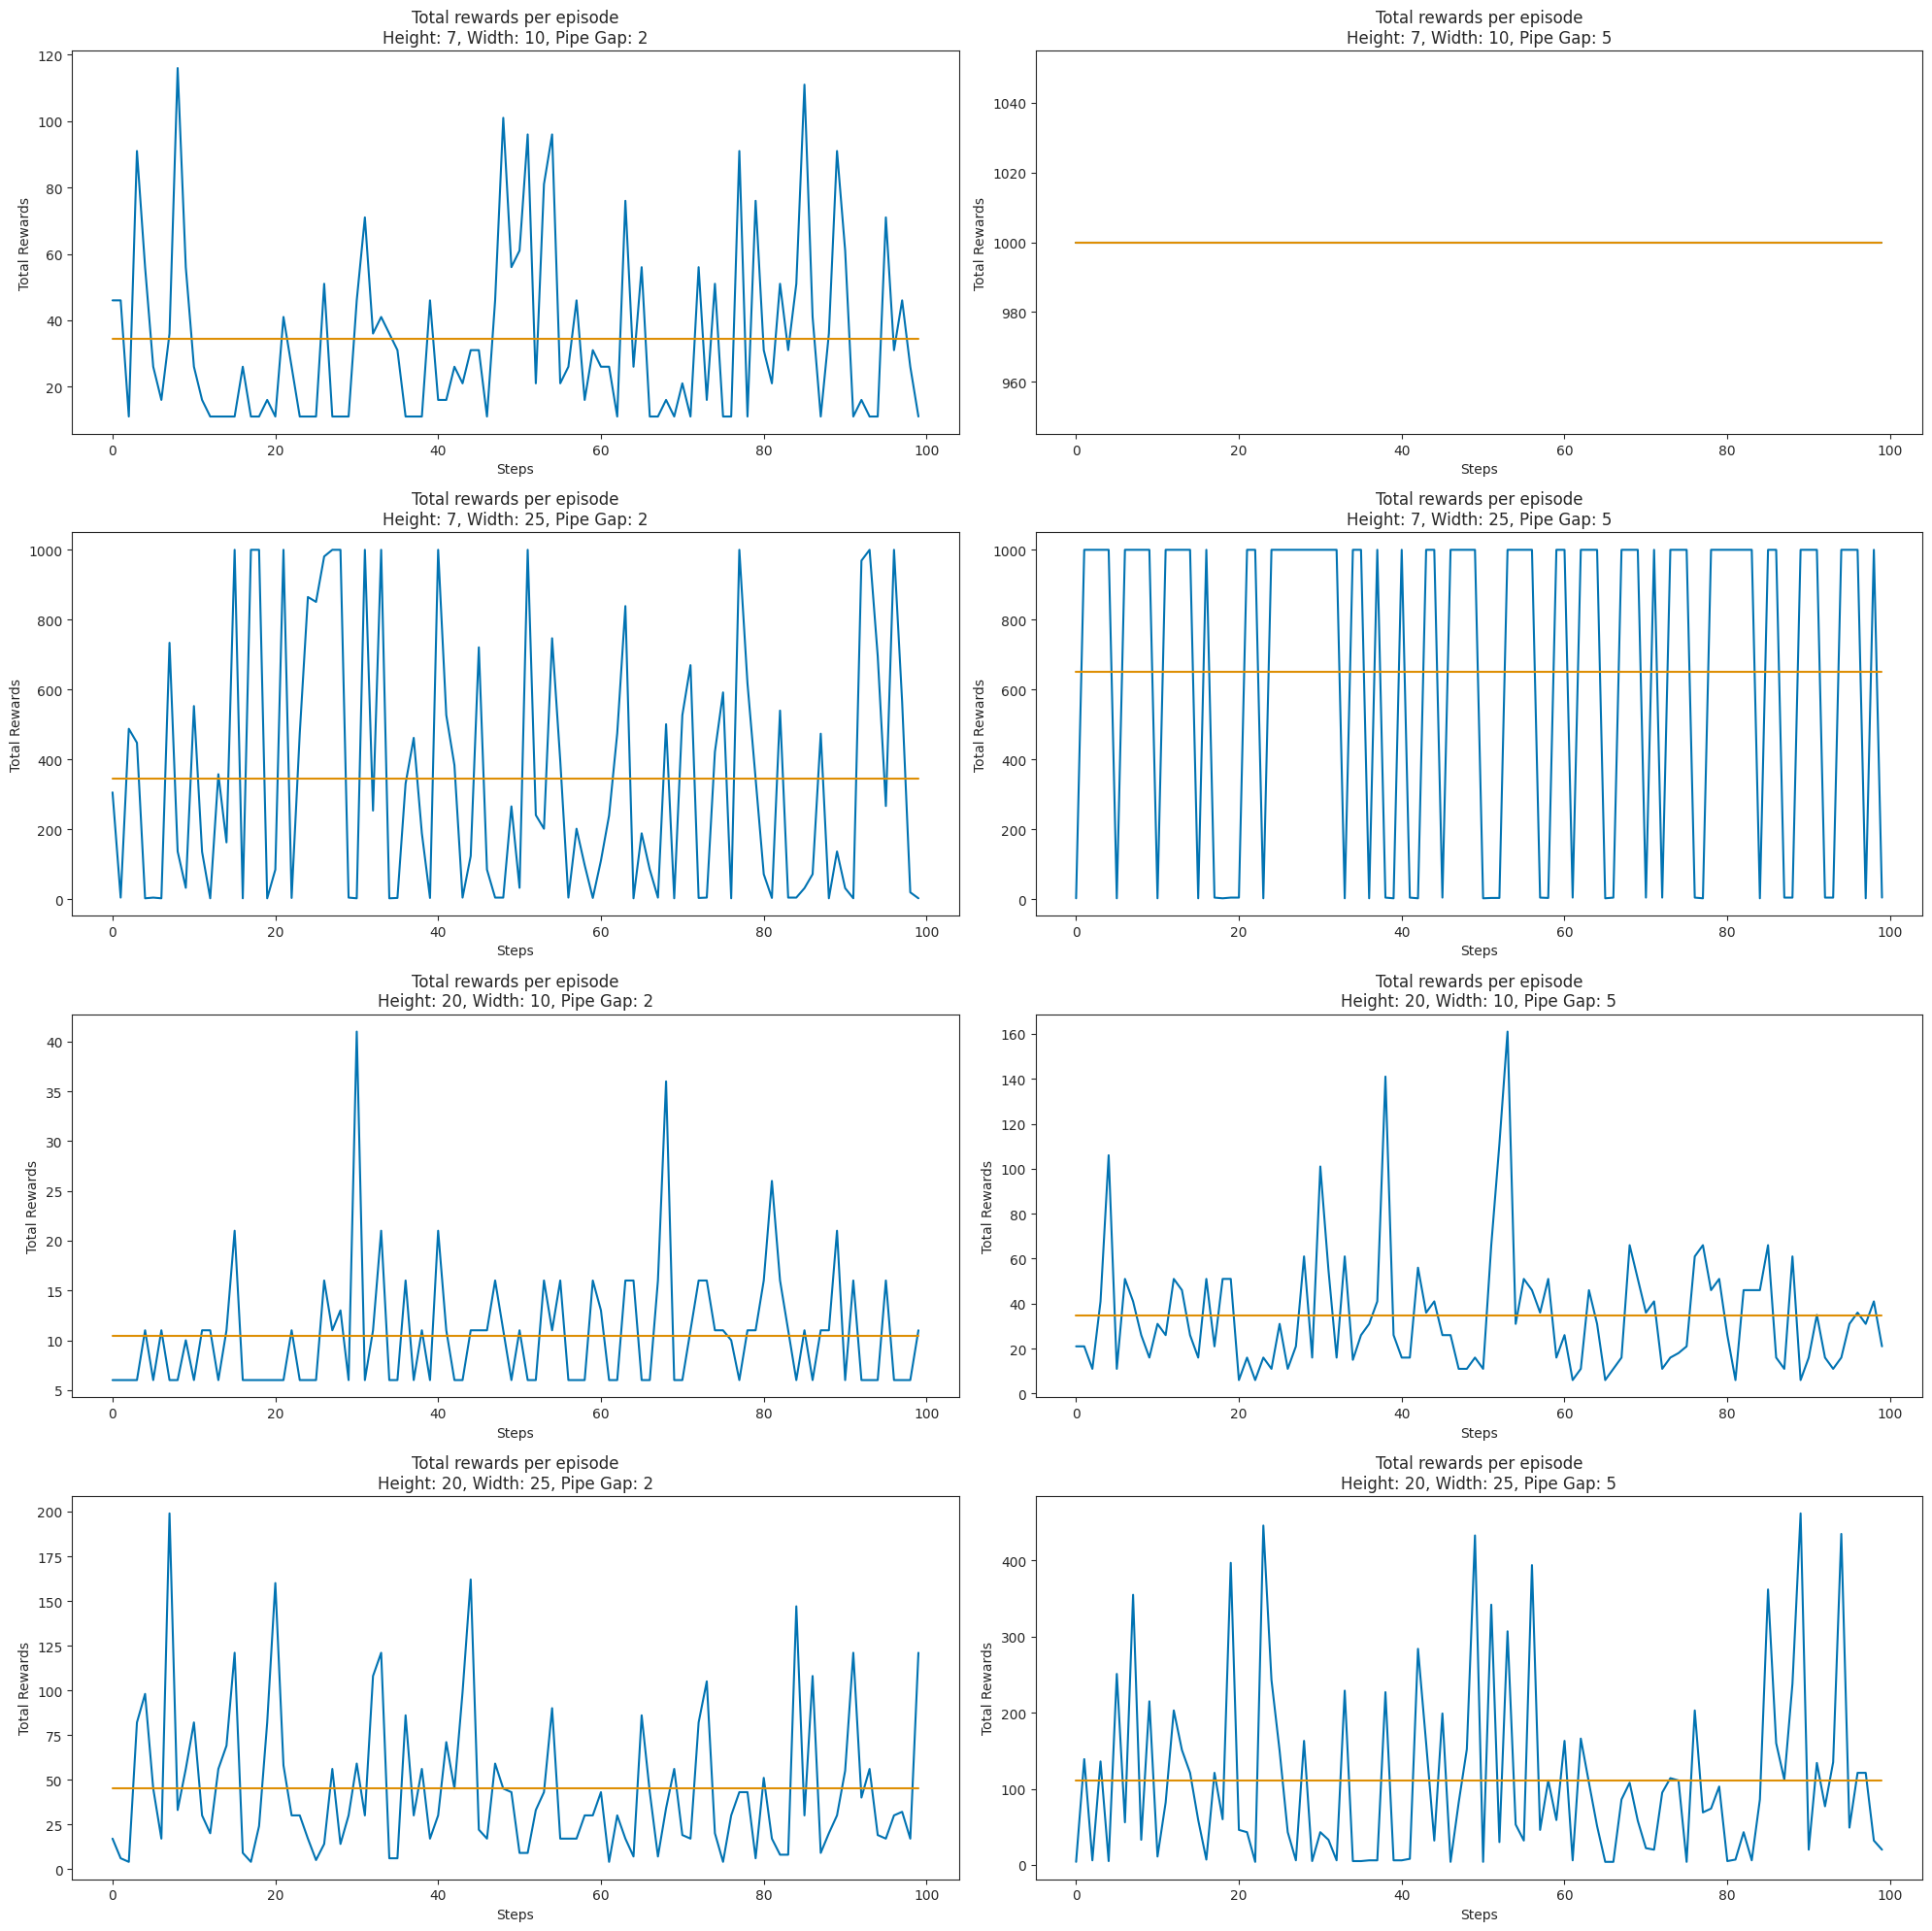

In [112]:
heights = [7, 20]
widths = [10, 25]
pipe_gaps = [2, 5]

fig, axs = plt.subplots(4, 2, figsize=(20, 20))

for i, (height, width, pipe_gap) in enumerate(itertools.product(heights, widths, pipe_gaps)):
    played_env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)
    n_total_rewards = []
    for _ in range(100):
        total_rewards = best_agent.play(played_env, epsilon=0)
        n_total_rewards.append(np.sum(total_rewards))
    
    row = i // 2
    col = i % 2
    axs[row, col].plot(n_total_rewards)
    axs[row, col].plot([np.mean(n_total_rewards)]*len(n_total_rewards))
    axs[row, col].set_title("Total rewards per episode\nHeight: {}, Width: {}, Pipe Gap: {}".format(height, width, pipe_gap))
    axs[row, col].set_xlabel("Steps")
    axs[row, col].set_ylabel("Total Rewards")


plt.tight_layout()
plt.show()

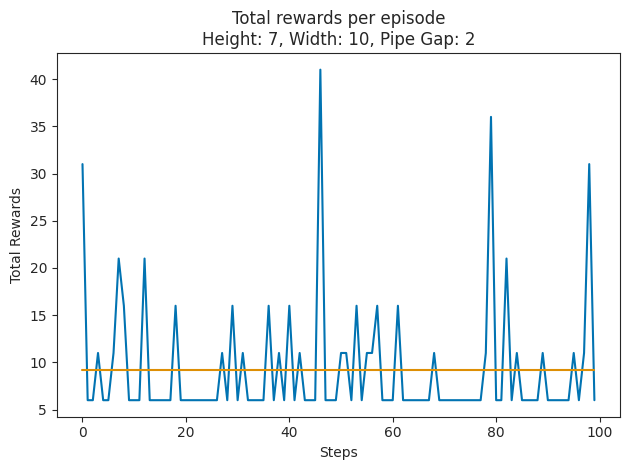

In [108]:
#Prepare various configurations settings for the tested environment
heights = 7
width = 10
pipe_gap = 2

played_env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)
n_total_rewards = []
for _ in range(100):
    total_rewards = best_agent.play(played_env, epsilon=0)
    n_total_rewards.append(np.sum(total_rewards))

plt.plot(n_total_rewards)
plt.plot([np.mean(n_total_rewards)]*len(n_total_rewards))
plt.title("Total rewards per episode\nHeight: {}, Width: {}, Pipe Gap: {}".format(height, width, pipe_gap))
plt.xlabel("Steps")
plt.ylabel("Total Rewards")
plt.tight_layout()
plt.show()

### Sarsa-$\lambda$ section

I ran a grid search analysis to tune the hyperparameters of my Lambda Sarsa method.

In [15]:

# Define the ranges for each parameter
epsilon_values = [0.1, 0.3, 0.5, 0.7]
alpha_values = [ 0.3, 0.5, 0.7]
gamma_values = [0.9, 0.95, 0.99]
lambd_values = [0.8, 0.9, 1.0]

# Initialize variables to store the best parameters and performance
best_params = None
best_performance = float('-inf')  # Assuming higher performance is better

# Perform the grid search
for epsilon, alpha, gamma, lambd in itertools.product(epsilon_values, alpha_values, gamma_values, lambd_values):
    # Create and train the agent with the current set of parameters
    sarsa_agent = SarsaLambdaAgent(env, alpha, gamma, lambd)
    rewards = sarsa_agent.train(num_episodes=1500, epsilon=epsilon)
    
    # Evaluate the performance of the trained agent
    performance = np.mean(rewards[-100:])
    
    # Check if the current set of parameters is the best so far
    if performance > best_performance:
        best_params = (epsilon, alpha, gamma, lambd)
        best_performance = performance
    print(f"epsilon={epsilon}, alpha={alpha}, gamma={gamma}, lambd={lambd}, performance={performance}")
# Print the best parameters and performance
print("Best Parameters:", best_params)
print("Best Performance:", best_performance)


100%|██████████| 1500/1500 [00:43<00:00, 34.59it/s]


epsilon=0.1, alpha=0.3, gamma=0.9, lambd=0.8, performance=118.91


100%|██████████| 1500/1500 [00:24<00:00, 61.60it/s]


epsilon=0.1, alpha=0.3, gamma=0.9, lambd=0.9, performance=35.79


100%|██████████| 1500/1500 [00:17<00:00, 84.09it/s]


epsilon=0.1, alpha=0.3, gamma=0.9, lambd=1.0, performance=43.41


100%|██████████| 1500/1500 [00:18<00:00, 81.01it/s]


epsilon=0.1, alpha=0.3, gamma=0.95, lambd=0.8, performance=26.73


100%|██████████| 1500/1500 [00:12<00:00, 119.09it/s]


epsilon=0.1, alpha=0.3, gamma=0.95, lambd=0.9, performance=13.62


100%|██████████| 1500/1500 [00:29<00:00, 50.06it/s]


epsilon=0.1, alpha=0.3, gamma=0.95, lambd=1.0, performance=68.55


100%|██████████| 1500/1500 [00:13<00:00, 113.28it/s]


epsilon=0.1, alpha=0.3, gamma=0.99, lambd=0.8, performance=21.84


100%|██████████| 1500/1500 [00:26<00:00, 57.61it/s]


epsilon=0.1, alpha=0.3, gamma=0.99, lambd=0.9, performance=43.54


100%|██████████| 1500/1500 [00:29<00:00, 51.01it/s]


epsilon=0.1, alpha=0.3, gamma=0.99, lambd=1.0, performance=36.84


100%|██████████| 1500/1500 [00:38<00:00, 39.29it/s]


epsilon=0.1, alpha=0.5, gamma=0.9, lambd=0.8, performance=62.16


100%|██████████| 1500/1500 [00:31<00:00, 48.21it/s]


epsilon=0.1, alpha=0.5, gamma=0.9, lambd=0.9, performance=65.67


100%|██████████| 1500/1500 [00:37<00:00, 39.91it/s]


epsilon=0.1, alpha=0.5, gamma=0.9, lambd=1.0, performance=82.06


100%|██████████| 1500/1500 [01:03<00:00, 23.46it/s]


epsilon=0.1, alpha=0.5, gamma=0.95, lambd=0.8, performance=87.22


100%|██████████| 1500/1500 [00:39<00:00, 38.07it/s]


epsilon=0.1, alpha=0.5, gamma=0.95, lambd=0.9, performance=168.23


100%|██████████| 1500/1500 [00:40<00:00, 37.01it/s]


epsilon=0.1, alpha=0.5, gamma=0.95, lambd=1.0, performance=34.48


100%|██████████| 1500/1500 [00:49<00:00, 30.05it/s]


epsilon=0.1, alpha=0.5, gamma=0.99, lambd=0.8, performance=276.72


100%|██████████| 1500/1500 [00:29<00:00, 50.53it/s]


epsilon=0.1, alpha=0.5, gamma=0.99, lambd=0.9, performance=27.82


100%|██████████| 1500/1500 [00:31<00:00, 48.04it/s]


epsilon=0.1, alpha=0.5, gamma=0.99, lambd=1.0, performance=26.77


100%|██████████| 1500/1500 [01:12<00:00, 20.71it/s]


epsilon=0.1, alpha=0.7, gamma=0.9, lambd=0.8, performance=220.92


100%|██████████| 1500/1500 [00:56<00:00, 26.36it/s]


epsilon=0.1, alpha=0.7, gamma=0.9, lambd=0.9, performance=85.89


100%|██████████| 1500/1500 [00:58<00:00, 25.82it/s]


epsilon=0.1, alpha=0.7, gamma=0.9, lambd=1.0, performance=62.93


100%|██████████| 1500/1500 [00:51<00:00, 29.03it/s]


epsilon=0.1, alpha=0.7, gamma=0.95, lambd=0.8, performance=125.23


100%|██████████| 1500/1500 [00:59<00:00, 25.02it/s]


epsilon=0.1, alpha=0.7, gamma=0.95, lambd=0.9, performance=59.12


100%|██████████| 1500/1500 [00:44<00:00, 34.09it/s]


epsilon=0.1, alpha=0.7, gamma=0.95, lambd=1.0, performance=40.63


100%|██████████| 1500/1500 [00:51<00:00, 29.22it/s]


epsilon=0.1, alpha=0.7, gamma=0.99, lambd=0.8, performance=124.39


100%|██████████| 1500/1500 [00:48<00:00, 30.77it/s]


epsilon=0.1, alpha=0.7, gamma=0.99, lambd=0.9, performance=65.18


100%|██████████| 1500/1500 [00:26<00:00, 57.16it/s]


epsilon=0.1, alpha=0.7, gamma=0.99, lambd=1.0, performance=22.51


100%|██████████| 1500/1500 [00:49<00:00, 30.51it/s]


epsilon=0.3, alpha=0.3, gamma=0.9, lambd=0.8, performance=188.9


100%|██████████| 1500/1500 [00:50<00:00, 29.79it/s]


epsilon=0.3, alpha=0.3, gamma=0.9, lambd=0.9, performance=151.49


100%|██████████| 1500/1500 [00:45<00:00, 33.12it/s]


epsilon=0.3, alpha=0.3, gamma=0.9, lambd=1.0, performance=109.83


100%|██████████| 1500/1500 [00:53<00:00, 28.26it/s]


epsilon=0.3, alpha=0.3, gamma=0.95, lambd=0.8, performance=223.74


100%|██████████| 1500/1500 [00:46<00:00, 32.13it/s]


epsilon=0.3, alpha=0.3, gamma=0.95, lambd=0.9, performance=88.45


100%|██████████| 1500/1500 [00:40<00:00, 37.20it/s]


epsilon=0.3, alpha=0.3, gamma=0.95, lambd=1.0, performance=71.31


100%|██████████| 1500/1500 [00:50<00:00, 29.90it/s]


epsilon=0.3, alpha=0.3, gamma=0.99, lambd=0.8, performance=387.14


100%|██████████| 1500/1500 [00:50<00:00, 29.63it/s]


epsilon=0.3, alpha=0.3, gamma=0.99, lambd=0.9, performance=99.69


100%|██████████| 1500/1500 [00:42<00:00, 35.13it/s]


epsilon=0.3, alpha=0.3, gamma=0.99, lambd=1.0, performance=89.85


100%|██████████| 1500/1500 [00:54<00:00, 27.74it/s]


epsilon=0.3, alpha=0.5, gamma=0.9, lambd=0.8, performance=154.05


100%|██████████| 1500/1500 [00:50<00:00, 29.68it/s]


epsilon=0.3, alpha=0.5, gamma=0.9, lambd=0.9, performance=154.22


100%|██████████| 1500/1500 [00:50<00:00, 29.65it/s]


epsilon=0.3, alpha=0.5, gamma=0.9, lambd=1.0, performance=110.13


100%|██████████| 1500/1500 [00:49<00:00, 30.42it/s]


epsilon=0.3, alpha=0.5, gamma=0.95, lambd=0.8, performance=125.49


100%|██████████| 1500/1500 [00:48<00:00, 30.80it/s]


epsilon=0.3, alpha=0.5, gamma=0.95, lambd=0.9, performance=86.59


100%|██████████| 1500/1500 [00:43<00:00, 34.73it/s]


epsilon=0.3, alpha=0.5, gamma=0.95, lambd=1.0, performance=44.96


100%|██████████| 1500/1500 [00:50<00:00, 29.44it/s]


epsilon=0.3, alpha=0.5, gamma=0.99, lambd=0.8, performance=158.22


100%|██████████| 1500/1500 [00:45<00:00, 32.86it/s]


epsilon=0.3, alpha=0.5, gamma=0.99, lambd=0.9, performance=55.28


100%|██████████| 1500/1500 [00:35<00:00, 41.84it/s]


epsilon=0.3, alpha=0.5, gamma=0.99, lambd=1.0, performance=72.62


100%|██████████| 1500/1500 [00:47<00:00, 31.56it/s]


epsilon=0.3, alpha=0.7, gamma=0.9, lambd=0.8, performance=77.19


100%|██████████| 1500/1500 [00:45<00:00, 33.16it/s]


epsilon=0.3, alpha=0.7, gamma=0.9, lambd=0.9, performance=121.04


100%|██████████| 1500/1500 [00:40<00:00, 37.31it/s]


epsilon=0.3, alpha=0.7, gamma=0.9, lambd=1.0, performance=61.12


100%|██████████| 1500/1500 [00:46<00:00, 32.19it/s]


epsilon=0.3, alpha=0.7, gamma=0.95, lambd=0.8, performance=91.3


100%|██████████| 1500/1500 [00:50<00:00, 29.82it/s]


epsilon=0.3, alpha=0.7, gamma=0.95, lambd=0.9, performance=67.0


100%|██████████| 1500/1500 [00:37<00:00, 39.79it/s]


epsilon=0.3, alpha=0.7, gamma=0.95, lambd=1.0, performance=49.63


100%|██████████| 1500/1500 [00:48<00:00, 31.12it/s]


epsilon=0.3, alpha=0.7, gamma=0.99, lambd=0.8, performance=89.25


100%|██████████| 1500/1500 [00:44<00:00, 33.71it/s]


epsilon=0.3, alpha=0.7, gamma=0.99, lambd=0.9, performance=56.38


100%|██████████| 1500/1500 [00:32<00:00, 46.48it/s]


epsilon=0.3, alpha=0.7, gamma=0.99, lambd=1.0, performance=21.95


100%|██████████| 1500/1500 [00:43<00:00, 34.74it/s]


epsilon=0.5, alpha=0.3, gamma=0.9, lambd=0.8, performance=232.67


100%|██████████| 1500/1500 [00:48<00:00, 31.15it/s]


epsilon=0.5, alpha=0.3, gamma=0.9, lambd=0.9, performance=186.64


100%|██████████| 1500/1500 [00:44<00:00, 34.08it/s]


epsilon=0.5, alpha=0.3, gamma=0.9, lambd=1.0, performance=157.84


100%|██████████| 1500/1500 [00:46<00:00, 31.92it/s]


epsilon=0.5, alpha=0.3, gamma=0.95, lambd=0.8, performance=141.87


100%|██████████| 1500/1500 [00:45<00:00, 33.15it/s]


epsilon=0.5, alpha=0.3, gamma=0.95, lambd=0.9, performance=184.12


100%|██████████| 1500/1500 [00:37<00:00, 39.70it/s]


epsilon=0.5, alpha=0.3, gamma=0.95, lambd=1.0, performance=91.22


100%|██████████| 1500/1500 [00:48<00:00, 31.14it/s]


epsilon=0.5, alpha=0.3, gamma=0.99, lambd=0.8, performance=123.64


100%|██████████| 1500/1500 [00:44<00:00, 33.87it/s]


epsilon=0.5, alpha=0.3, gamma=0.99, lambd=0.9, performance=422.59


100%|██████████| 1500/1500 [00:37<00:00, 40.26it/s]


epsilon=0.5, alpha=0.3, gamma=0.99, lambd=1.0, performance=74.21


100%|██████████| 1500/1500 [00:42<00:00, 35.08it/s]


epsilon=0.5, alpha=0.5, gamma=0.9, lambd=0.8, performance=73.19


100%|██████████| 1500/1500 [00:42<00:00, 35.53it/s]


epsilon=0.5, alpha=0.5, gamma=0.9, lambd=0.9, performance=118.88


100%|██████████| 1500/1500 [00:36<00:00, 41.50it/s]


epsilon=0.5, alpha=0.5, gamma=0.9, lambd=1.0, performance=121.11


100%|██████████| 1500/1500 [00:41<00:00, 35.84it/s]


epsilon=0.5, alpha=0.5, gamma=0.95, lambd=0.8, performance=163.94


100%|██████████| 1500/1500 [00:38<00:00, 38.98it/s]


epsilon=0.5, alpha=0.5, gamma=0.95, lambd=0.9, performance=99.36


100%|██████████| 1500/1500 [00:36<00:00, 41.23it/s]


epsilon=0.5, alpha=0.5, gamma=0.95, lambd=1.0, performance=156.18


100%|██████████| 1500/1500 [00:40<00:00, 36.89it/s]


epsilon=0.5, alpha=0.5, gamma=0.99, lambd=0.8, performance=208.19


100%|██████████| 1500/1500 [00:37<00:00, 40.46it/s]


epsilon=0.5, alpha=0.5, gamma=0.99, lambd=0.9, performance=158.2


100%|██████████| 1500/1500 [00:38<00:00, 39.06it/s]


epsilon=0.5, alpha=0.5, gamma=0.99, lambd=1.0, performance=74.15


100%|██████████| 1500/1500 [00:38<00:00, 38.81it/s]


epsilon=0.5, alpha=0.7, gamma=0.9, lambd=0.8, performance=132.53


100%|██████████| 1500/1500 [00:37<00:00, 39.57it/s]


epsilon=0.5, alpha=0.7, gamma=0.9, lambd=0.9, performance=75.47


100%|██████████| 1500/1500 [00:34<00:00, 43.16it/s]


epsilon=0.5, alpha=0.7, gamma=0.9, lambd=1.0, performance=51.37


100%|██████████| 1500/1500 [00:40<00:00, 37.02it/s]


epsilon=0.5, alpha=0.7, gamma=0.95, lambd=0.8, performance=79.0


100%|██████████| 1500/1500 [00:36<00:00, 41.34it/s]


epsilon=0.5, alpha=0.7, gamma=0.95, lambd=0.9, performance=41.32


100%|██████████| 1500/1500 [00:32<00:00, 45.93it/s]


epsilon=0.5, alpha=0.7, gamma=0.95, lambd=1.0, performance=44.72


100%|██████████| 1500/1500 [00:38<00:00, 38.94it/s]


epsilon=0.5, alpha=0.7, gamma=0.99, lambd=0.8, performance=146.04


100%|██████████| 1500/1500 [00:38<00:00, 38.99it/s]


epsilon=0.5, alpha=0.7, gamma=0.99, lambd=0.9, performance=53.36


100%|██████████| 1500/1500 [00:30<00:00, 48.55it/s]


epsilon=0.5, alpha=0.7, gamma=0.99, lambd=1.0, performance=87.12


100%|██████████| 1500/1500 [00:37<00:00, 40.53it/s]


epsilon=0.7, alpha=0.3, gamma=0.9, lambd=0.8, performance=179.42


100%|██████████| 1500/1500 [00:33<00:00, 44.23it/s]


epsilon=0.7, alpha=0.3, gamma=0.9, lambd=0.9, performance=66.44


100%|██████████| 1500/1500 [00:36<00:00, 41.66it/s]


epsilon=0.7, alpha=0.3, gamma=0.9, lambd=1.0, performance=183.32


100%|██████████| 1500/1500 [00:36<00:00, 40.80it/s]


epsilon=0.7, alpha=0.3, gamma=0.95, lambd=0.8, performance=105.42


100%|██████████| 1500/1500 [00:34<00:00, 43.01it/s]


epsilon=0.7, alpha=0.3, gamma=0.95, lambd=0.9, performance=177.04


100%|██████████| 1500/1500 [00:34<00:00, 43.30it/s]


epsilon=0.7, alpha=0.3, gamma=0.95, lambd=1.0, performance=134.76


100%|██████████| 1500/1500 [00:39<00:00, 38.18it/s]


epsilon=0.7, alpha=0.3, gamma=0.99, lambd=0.8, performance=142.94


100%|██████████| 1500/1500 [00:34<00:00, 43.87it/s]


epsilon=0.7, alpha=0.3, gamma=0.99, lambd=0.9, performance=205.61


100%|██████████| 1500/1500 [00:32<00:00, 46.15it/s]


epsilon=0.7, alpha=0.3, gamma=0.99, lambd=1.0, performance=210.31


100%|██████████| 1500/1500 [00:35<00:00, 42.07it/s]


epsilon=0.7, alpha=0.5, gamma=0.9, lambd=0.8, performance=181.04


100%|██████████| 1500/1500 [00:32<00:00, 46.61it/s]


epsilon=0.7, alpha=0.5, gamma=0.9, lambd=0.9, performance=76.17


100%|██████████| 1500/1500 [00:29<00:00, 50.01it/s]


epsilon=0.7, alpha=0.5, gamma=0.9, lambd=1.0, performance=125.64


100%|██████████| 1500/1500 [00:35<00:00, 42.69it/s]


epsilon=0.7, alpha=0.5, gamma=0.95, lambd=0.8, performance=215.72


100%|██████████| 1500/1500 [00:33<00:00, 44.29it/s]


epsilon=0.7, alpha=0.5, gamma=0.95, lambd=0.9, performance=109.89


100%|██████████| 1500/1500 [00:31<00:00, 47.21it/s]


epsilon=0.7, alpha=0.5, gamma=0.95, lambd=1.0, performance=81.09


100%|██████████| 1500/1500 [00:35<00:00, 42.02it/s]


epsilon=0.7, alpha=0.5, gamma=0.99, lambd=0.8, performance=193.37


100%|██████████| 1500/1500 [00:33<00:00, 45.30it/s]


epsilon=0.7, alpha=0.5, gamma=0.99, lambd=0.9, performance=102.02


100%|██████████| 1500/1500 [00:30<00:00, 48.81it/s]


epsilon=0.7, alpha=0.5, gamma=0.99, lambd=1.0, performance=56.45


100%|██████████| 1500/1500 [00:33<00:00, 45.02it/s]


epsilon=0.7, alpha=0.7, gamma=0.9, lambd=0.8, performance=180.49


100%|██████████| 1500/1500 [00:32<00:00, 45.47it/s]


epsilon=0.7, alpha=0.7, gamma=0.9, lambd=0.9, performance=62.79


100%|██████████| 1500/1500 [00:29<00:00, 50.66it/s]


epsilon=0.7, alpha=0.7, gamma=0.9, lambd=1.0, performance=166.61


100%|██████████| 1500/1500 [00:33<00:00, 44.76it/s]


epsilon=0.7, alpha=0.7, gamma=0.95, lambd=0.8, performance=87.25


100%|██████████| 1500/1500 [00:32<00:00, 46.46it/s]


epsilon=0.7, alpha=0.7, gamma=0.95, lambd=0.9, performance=82.86


100%|██████████| 1500/1500 [00:30<00:00, 48.89it/s]


epsilon=0.7, alpha=0.7, gamma=0.95, lambd=1.0, performance=33.72


100%|██████████| 1500/1500 [00:32<00:00, 46.82it/s]


epsilon=0.7, alpha=0.7, gamma=0.99, lambd=0.8, performance=125.41


100%|██████████| 1500/1500 [00:34<00:00, 43.96it/s]


epsilon=0.7, alpha=0.7, gamma=0.99, lambd=0.9, performance=140.96


100%|██████████| 1500/1500 [00:29<00:00, 50.08it/s]

epsilon=0.7, alpha=0.7, gamma=0.99, lambd=1.0, performance=56.82
Best Parameters: (0.5, 0.3, 0.99, 0.9)
Best Performance: 422.59
